## Learn the inverse of log-signature (pytorch)

In [116]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import signatory

def leadlag(p):
    B = p.size()[0]
    p = torch.cat([p[:,:,None],p[:,:,None]],axis = -1)
    p = p.view([B,-1])
    p = torch.cat([p[:,:-1,None],p[:,1:,None]],axis = -1)
    return p
def leadlag_inverse(p):
    return p[0::2,0]
def generate_bmpath(batch, N):
    T = 1
    dt = T/N
    path_diff = np.random.normal(size = [batch,N,d]) * np.sqrt(dt)
    path = np.cumsum(path_diff,axis = 1)
    path = np.concatenate([np.zeros([batch,1,d]), path], axis = 1)
    return path
class Dataset(torch.utils.data.Dataset):
        def __init__(self, X):
            self.X = X
        def __len__(self):
            return len(self.X)
        def __getitem__(self, index):
            return X[index]
def data_prepare(X,y):
    batch = y.shape[0]
    if batch > 1:
        split = int(batch/2)
        X_train = X[:split]
        y_train = y[:split]

        X_test = X[split:]
        y_test = y[split:]

        ds = Dataset(torch.tensor(X_train,dtype = torch.float32))
        dl = torch.utils.data.DataLoader(ds, batch_size=64)
        return dl, X_train, y_train, X_test, y_test
        
    else:
        dl = torch.tensor(X)[None,:,:]
        return dl
    

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self, input_dim, order, N):
        super(Net, self).__init__()
        self.N = N
        self.order = order
        self.fc1 = nn.Linear(input_dim,200)  
        self.fc2 = nn.Linear(200,200)
        self.fc3 = nn.Linear(200,N*10)
        self.fc4 = nn.Linear(10,d)
        self.logsig1 = signatory.LogSignature(depth=order)
    def forward(self, x):
        B = x.size()[0]
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = x.view([-1,N,10])
        x = self.fc4(x)
        x = torch.cumsum(x,axis = 1)
        x = torch.cat([torch.zeros(size = [B,1,1]),x], axis = 1)
        x = leadlag(x)
        sig = self.logsig1(x, basepoint = True)
        return x, sig
    def train_net(self, dl, epochs):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=0.003)
        for epoch in range(epochs):  # loop over the dataset multiple times
            running_loss = 0.0
            for i, x in enumerate(dl):
                optimizer.zero_grad()
                x = x.float()
                p, x_re = self.__call__(x)
                loss = criterion(x, x_re)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            if epoch%100 == 0:    
                print('step: ',epoch,'loss: ', running_loss)
        print('Finished Training')

def reconstruct_plot(X,y):
    with torch.no_grad():  
        X = torch.tensor(X, dtype = torch.float)
        y_predict, X_predict = net(X)
        lo = criterion(X, X_predict)
    print('LOSS is: ', lo.numpy())
    
    if batch > 1:
        plt.figure(figsize=(16, 4))
        for i in range(8):
            plt.subplot(2, 4, i + 1)
            idx = np.random.randint(0,split)
            plt.plot(leadlag_inverse(y[idx]))
            plt.plot(leadlag_inverse(y_predict[idx]))
    else:
        logsig_recover = signatory.logsignature(y_predict, order)
        plt.plot(leadlag_inverse(y[0]))
        plt.plot(leadlag_inverse(y_predict[0]))
        return y_predict, logsig_recover 
    plt.show()

In [112]:
N = 20
batch = 1000
split = int(batch/2)
path = generate_bmpath(batch, N)
path_torch = leadlag(torch.tensor(path)[:,:,0])
path_leadlag = path_torch.numpy()
order = 5
logsig = signatory.logsignature(path_torch, order)

In [113]:
X = logsig.numpy()
y = path_leadlag
dl, X_train, y_train, X_test, y_test = data_prepare(X,y)
net = Net(X.shape[-1],order,N)
net.train_net(dl,2000)

step:  0 loss:  4.798550337553024
step:  100 loss:  0.00805570968077518
step:  200 loss:  0.004670369147788733
step:  300 loss:  0.002893880329793319
step:  400 loss:  0.0038039624923840165
step:  500 loss:  0.003795907978201285
step:  600 loss:  0.003025697194971144
step:  700 loss:  0.004886221373453736
step:  800 loss:  0.003174123034114018
step:  900 loss:  0.003894524634233676
step:  1000 loss:  0.0015086548228282481
step:  1100 loss:  0.0016030479018809274
step:  1200 loss:  0.001374475468765013
step:  1300 loss:  0.001973567108507268
step:  1400 loss:  0.0032784080249257386
step:  1500 loss:  0.0014655418635811657
step:  1600 loss:  0.0015034475072752684
step:  1700 loss:  0.0012249419232830405
step:  1800 loss:  0.010772256937343627
step:  1900 loss:  0.00406583322910592
Finished Training


in sample compare
LOSS is:  0.00041312145


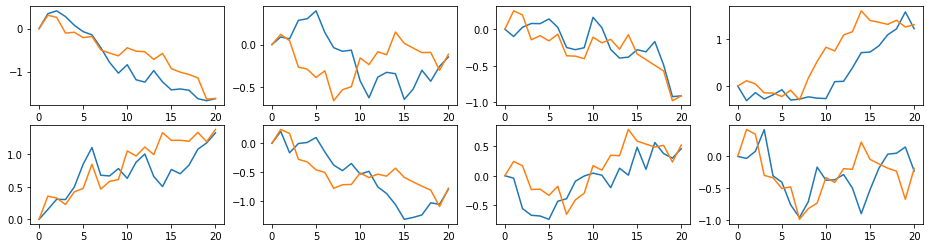

out sample compare
LOSS is:  0.0005911885


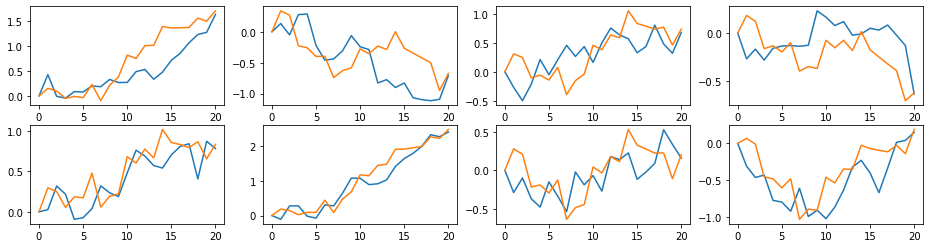

In [114]:
print('in sample compare')
reconstruct_plot(X_train,y_train)

print('out sample compare')
reconstruct_plot(X_test, y_test)

## Reverse a single path

In [125]:
N = 20
batch = 1
path = generate_bmpath(batch, N)
path_torch = leadlag(torch.tensor(path)[:,:,0])
path_leadlag = path_torch.numpy()
order = 5
logsig = signatory.logsignature(path_torch, order)

X0 = logsig.numpy()
y0 = path_leadlag
dl = data_prepare(X0,y0)
net0 = Net(X0.shape[-1],order,N)
net0.train_net(dl,1000)

step:  0 loss:  0.04305677488446236
step:  100 loss:  2.5762356017366983e-05
step:  200 loss:  1.1194243597856257e-05
step:  300 loss:  5.778834747616202e-06
step:  400 loss:  4.027705017506378e-06
step:  500 loss:  3.6550288768921746e-06
step:  600 loss:  3.756665819310001e-06
step:  700 loss:  3.3884844015119597e-06
step:  800 loss:  4.584494945447659e-06
step:  900 loss:  3.484361968730809e-06
Finished Training


LOSS is:  0.000965119


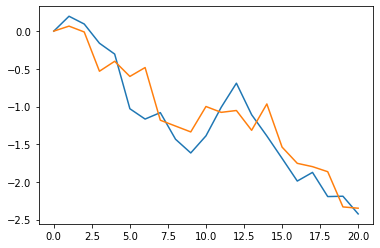

In [126]:
y_predict, logsig_recover = reconstruct_plot(X0, y0)

In [128]:
import base
import logsig_inversion
pip = 0.01
n_pips = 10
n_points = N+1
order = 5
n_iterations = 100
n_organisms = 1000
recovered_path, loss = logsig_inversion.train(X0[0], order, n_iterations, n_organisms, n_points,
                                              pip, n_pips)

In [129]:
logsig_recover2 = signatory.logsignature(leadlag(torch.tensor(recovered_path)[None,:]), order)
logsig_recover2.float()
XX = torch.tensor(X0, dtype = torch.float)
print('True log signature: \n', XX[0])
print('Neural log signature: \n', logsig_recover[0])
print('Evolution log signature: \n', logsig_recover2[0])

True log signature: 
 tensor([-2.4250, -2.4250, -0.8735, -0.1811,  0.0908,  0.0470, -0.1383,  0.0746,
         0.0187, -0.0572,  0.0912,  0.0493, -0.1618, -0.0126])
Neural log signature: 
 tensor([-2.3492, -2.3492, -0.8818, -0.1720,  0.0512,  0.0493, -0.1416,  0.0713,
         0.0200, -0.0591,  0.1047,  0.0508, -0.1527, -0.0140])
Evolution log signature: 
 tensor([-2.0000e+00, -2.0000e+00, -1.0000e-01, -1.6667e-03, -1.6667e-03,
        -4.4409e-16, -8.3333e-05, -2.2204e-16,  2.7778e-07, -1.1111e-06,
         1.6667e-06, -1.1111e-06,  1.6667e-06,  2.7778e-07],
       dtype=torch.float64)


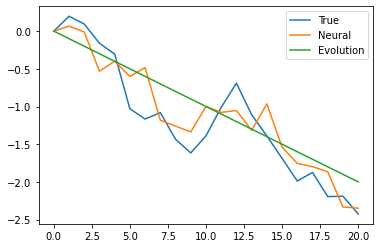

In [130]:
plt.plot(leadlag_inverse(y0[0]))
plt.plot(leadlag_inverse(y_predict[0]))
plt.plot(recovered_path)
plt.legend(['True', 'Neural', 'Evolution'])
plt.show()

## Time augmentation with direct computation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import signatory
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import base
from Sig_method import sig_stream2

d = 1
D = d+1
T = .1
N = 20
dt = T/N
batch = 1
time_aug = np.ones(shape = [batch,N,1])*dt

bm = np.random.normal(size = [batch,N,d]) * np.sqrt(dt)
BM = np.concatenate([time_aug, bm], axis = -1)
BM = np.cumsum(BM,axis = 1)
BM = np.concatenate([np.zeros([batch,1,D]), BM], axis = 1)

BM2 = BM[:,0::2,:]
plt.plot(BM[0,:,0],BM[0,:,1])
plt.plot(BM[0,0::2,0],BM[0,0::2,1])

order = 10

all_word = signatory.all_words(D,order)
sig = sig_stream2(BM[0], order)[0,-1].numpy()
logsig = signatory.signature_to_logsignature(torch.tensor(sig[None,1:]),D,order)[0].numpy()

sig2 = sig_stream2(BM2[0], order)[0,-1].numpy()
logsig2 = signatory.signature_to_logsignature(torch.tensor(sig2[None,1:]),D,order)[0].numpy()

l = np.zeros(order)
for n in range(order):
    nn = int(D**order + D**n - 1)
    l[-n-1] = sig[nn]/(2*dt)**(order-1)

l2 = np.zeros(order)
for n in range(order):
    nn = int(D**order + D**n - 1)
    l2[-n-1] = sig2[nn]/(2*dt)**(order-1)
    
plt.plot(np.cumsum(l))
plt.plot(np.cumsum(l2))
plt.plot(BM2[0,1:,1])

## Tensorflow

In [53]:
input_dim = X.shape[1:]
output_dim = y.shape[1:]

inputs = keras.Input(shape = input_dim)
x = layers.Dense(units = 250, activation = 'relu')(inputs)
x = layers.Dropout(0.05)(x)
x = layers.Dense(units = 250, activation = 'relu')(x)
x = layers.Dropout(0.05)(x)
x = layers.Dense(units = 250, activation = 'relu')(x)
x = layers.Dropout(0.05)(x)
x = layers.Dense(units = d*N, activation = 'linear')(x)
outputs = layers.Reshape(output_dim)(x)
model = keras.Model(inputs = inputs, outputs = outputs)

In [54]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 14)]              0         
_________________________________________________________________
dense_20 (Dense)             (None, 250)               3750      
_________________________________________________________________
dropout_15 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 250)               62750     
_________________________________________________________________
dropout_16 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 250)               62750     
_________________________________________________________________
dropout_17 (Dropout)         (None, 250)               0   

In [55]:
model.compile(loss = 'mse')
model.fit(x = X_train, y = y_train, epochs = 1000)

Epoch 1/1000
16/16 [==============================] - 1s 3ms/step - loss: 0.0182
Epoch 2/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.0163
Epoch 3/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.0158
Epoch 4/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 5/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.0152
Epoch 6/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 7/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.0149
Epoch 8/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 9/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.0149
Epoch 10/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.0150
Epoch 11/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 12/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 13/1000
16/16 [====

16/16 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 102/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.0103
Epoch 103/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 104/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 105/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 106/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 107/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 108/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 109/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 110/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 111/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 112/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 113/1000
16/1

16/16 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 298/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0050
Epoch 299/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch 300/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0050
Epoch 301/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch 302/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0049
Epoch 303/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0051
Epoch 304/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0050
Epoch 305/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0051
Epoch 306/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 307/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch 308/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0048
Epoch 309/1000
16/1

16/16 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 494/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 495/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 496/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 497/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 498/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 499/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 500/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 501/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 502/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 503/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 504/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 505/1000
16/1

16/16 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 689/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 690/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 691/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0021
Epoch 692/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 693/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 694/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 695/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 696/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 697/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 698/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 699/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 700/1000
16/1

16/16 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 885/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 886/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 887/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 888/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 889/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 890/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 891/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 892/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 893/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 894/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 895/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 896/1000
16/1

In [56]:
y_train_predict = model.predict(X_train)

path = np.cumsum(y_train_predict,axis = 1)
path = np.concatenate([np.zeros([split,1,d]), path], axis = 1)
path = torch.tensor(path)
logsig_train_predict = signatory.logsignature(path, order)
logsig_train_predict = logsig_train_predict.numpy()

np.sqrt(np.sum((logsig_train_predict - X_train)**2,axis =1)).mean()

0.03182473241370549

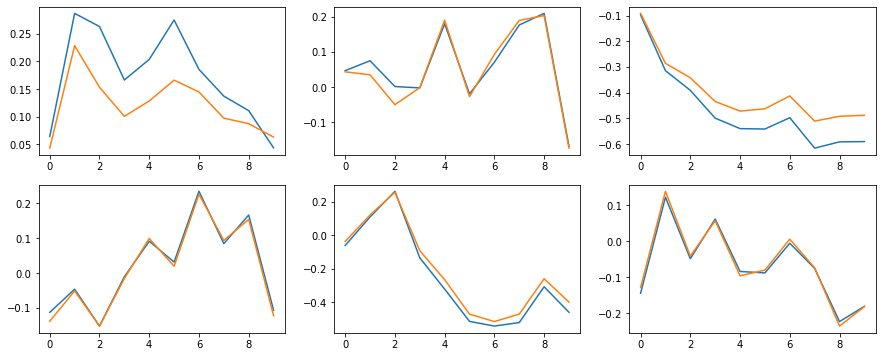

In [57]:
plt.figure(figsize=(15, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    idx = np.random.randint(0,500)
    plt.plot(np.cumsum(y_train[idx]))
    plt.plot(np.cumsum(y_train_predict[idx]))

In [58]:
y_test_predict = model.predict(X_test)

path = np.cumsum(y_train_predict,axis = 1)
path = np.concatenate([np.zeros([split,1,d]), path], axis = 1)
path = torch.tensor(path)
logsig_test_predict = signatory.logsignature(path, order)
logsig_test_predict = logsig_test_predict.numpy()

np.sqrt(np.sum((logsig_test_predict - X_test)**2,axis =1)).mean()

0.5732185350199887

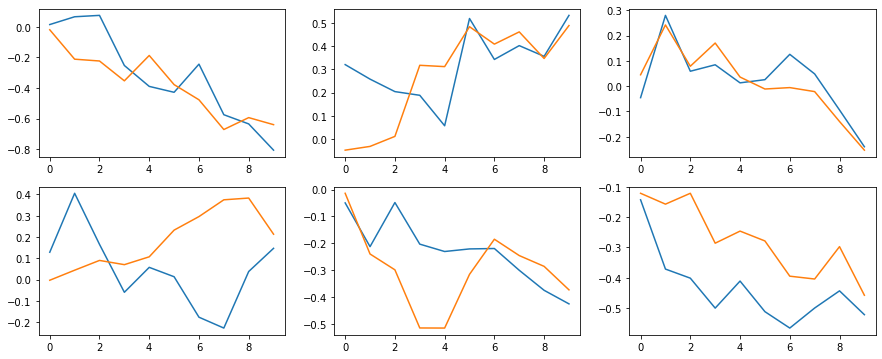

In [59]:
plt.figure(figsize=(15, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    idx = np.random.randint(0,500)
    plt.plot(np.cumsum(y_test[idx]))
    
    plt.plot(np.cumsum(y_test_predict[idx]))

In [19]:
import signatory
import torch
from torch import nn


class SigNet3(nn.Module):
    def __init__(self, in_channels, out_dimension, sig_depth):
        super(SigNet3, self).__init__()
        self.augment1 = signatory.Augment(in_channels=in_channels,
                                          layer_sizes=(8, 8, 4),
                                          kernel_size=4,
                                          include_original=True,
                                          include_time=True)
        self.signature1 = signatory.Signature(depth=sig_depth,
                                              stream=True)

        sig_channels1 = signatory.signature_channels(channels=in_channels + 5,
                                                     depth=sig_depth)
        self.augment2 = signatory.Augment(in_channels=sig_channels1,
                                          layer_sizes=(8, 8, 4),
                                          kernel_size=4,
                                          include_original=False,
                                          include_time=False)
        
        self.signature2 = signatory.Signature(depth=sig_depth,
                                              stream=False)

        # 4 because that's the final layer size in self.augment2
        sig_channels2 = signatory.signature_channels(channels=4,
                                                     depth=sig_depth)
        self.linear = torch.nn.Linear(sig_channels2, out_dimension)

    def forward(self, inp):
        # inp is a three dimensional tensor of shape (batch, stream, in_channels)
        a = self.augment1(inp)
        if a.size(1) <= 1:
            raise RuntimeError("Given an input with too short a stream to take the"
                               " signature")
        # a in a three dimensional tensor of shape (batch, stream, in_channels + 5)
        b = self.signature1(a, basepoint=True)
        # b is a three dimensional tensor of shape (batch, stream, sig_channels1)
        c = self.augment2(b)
        if c.size(1) <= 1:
            raise RuntimeError("Given an input with too short a stream to take the"
                               " signature")
        # c is a three dimensional tensor of shape (batch, stream, 4)
        d = self.signature2(c, basepoint=True)
        # d is a two dimensional tensor of shape (batch, sig_channels2)
        e = self.linear(d)
        # e is a two dimensional tensor of shape (batch, out_dimension)
        return e

In [18]:
path = torch.randn(size = [1,10,2])
model.signature(model.augment(path))

tensor([[ 1.6331e+00,  7.7790e-01,  1.0000e+00,  1.3336e+00, -1.6283e+00,
         -1.5002e-03,  2.8987e+00,  3.0256e-01,  1.2185e+00,  1.6346e+00,
         -4.4060e-01,  5.0000e-01,  7.2598e-01, -1.2330e-02,  3.4841e-01,
         -2.6345e+00, -3.4676e-02, -7.4722e-01, -6.9926e-01, -1.7303e-01,
         -2.0902e-01,  3.6843e+00, -1.1973e+00,  9.1908e-01,  1.7261e+00,
          7.8454e-02,  9.3331e-01,  1.8181e+00, -9.1875e-01,  4.8579e-01,
          1.6844e+00, -7.0802e-01,  4.1653e-01,  1.6148e-01,  2.8800e-01,
          2.4691e-01,  6.0906e-01, -3.4376e-01,  1.6667e-01]])

In [5]:
model = SigNet(2,3,3)
model

SigNet(
  (augment): Augment(
    activation=<function relu at 0x00000197320A0310>, include_original=True, include_time=True
    (convs): ModuleList()
  )
  (signature): Signature(depth=3, stream=False, inverse=False)
  (linear): Linear(in_features=39, out_features=3, bias=True)
)

In [41]:
import numpy as np
from esig import tosig
from tqdm.auto import tqdm
from scipy.optimize import brentq
from joblib import Parallel, delayed
import ast

# max_norm_square = 2.


def Sig_TU2(X,Y,kern):
    kxx = kern(X,X)
    kxy = kern(X,Y)
    kyy = kern(Y,Y)
    m = X.shape[0]
    n = Y.shape[0]
    TU = 0.
    TU += (np.sum(kxx) - np.trace(kxx)) / (m * (m-1))
    TU += (np.sum(kyy)-np.trace(kyy)) / (n * (n-1))
    TU -= 2 * np.sum(kxy) / (m * n)
    return TU

def transform(sig, phi_x, keys):
    Lambda = np.array([phi_x ** len(t) for t in keys])
    return Lambda * sig

def psi(x, M=4, a=1):
    x = x ** 2
    if x <= M:
        return x
    return M + M ** (1 + a) * (M ** (-a) - x ** (-a)) / a

def norm(x):
    return np.linalg.norm(x)

def phi(x, order, keys):
    x = np.array(x)

    a = x ** 2
    a[0] -= psi(norm(x))

#     a[0] -= max_norm_square
    
    
    f = lambda z: np.dot(a, [z ** (2 * len(keys[i])) for i in range(len(a))])

    return brentq(f, 0, 100)


def get_keys(dim, order):
    s = tosig.sigkeys(dim, order)

    tuples = []

    for t in s.split():
        if len(t) > 2:
            t = t.replace(")", ",)")

        tuples.append(ast.literal_eval(t))

    return tuples

def Phi(X, order, normalise=True, compute_sigs=True):
    if compute_sigs:
        dim = np.shape(X)[1]
        sig = tosig.stream2sig(np.array(X), order)
    else:
        dim = 2
        sig = np.array(X)

    if not normalise:
        return sig
    
    print(np.linalg.norm(sig)**2)
    
    keys = get_keys(dim, order)

    phi_x = phi(tuple(sig), order, keys)
    Lambda = np.array([phi_x ** len(t) for t in keys])

    print(np.linalg.norm(Lambda * sig)**2)
    
    return Lambda * sig

def T(set1, set2, order, verbose=True, normalise=True, compute_sigs=True):
    m = len(set1)
    n = len(set2)

    X = Parallel(n_jobs=1)(delayed(Phi)(path, order, normalise, compute_sigs) for path in tqdm(set1, desc="Computing signatures of population 1", disable=(not verbose)))
    Y = Parallel(n_jobs=1)(delayed(Phi)(path, order, normalise, compute_sigs) for path in tqdm(set2, desc="Computing signatures of population 2", disable=(not verbose)))

    XX = np.dot(X, np.transpose(X))
    YY = np.dot(Y, np.transpose(Y))
    XY = np.dot(X, np.transpose(Y))

    TU = 0.
    TU += XX.sum() / (m * m)
    TU += YY.sum() / (n * n)
    TU -= 2 * XY.sum() / (m * n)


    return TU



def Phi_global(X, order, normalise=True, compute_sigs=True):
    if compute_sigs:
        dim = np.shape(X)[1]
        sig = tosig.stream2sig(np.array(X), order)
    else:
        dim = 2
        sig = np.array(X)

    if not normalise:
        return sig
    
    print(np.linalg.norm(sig)**2)
    
    keys = get_keys(dim, order)

    phi_x = phi(tuple(sig), order, keys)
    
    return sig, phi_x

    

def T_global(set1, set2, order, verbose=True, normalise=True, compute_sigs=True):
    
    
    
    m = len(set1)
    n = len(set2)

    X_pre = Parallel(n_jobs=1)(delayed(Phi_global)(path, order, normalise, compute_sigs) for path in tqdm(set1, desc="Computing signatures of population 1", disable=(not verbose)))
    Y_pre = Parallel(n_jobs=1)(delayed(Phi_global)(path, order, normalise, compute_sigs) for path in tqdm(set2, desc="Computing signatures of population 2", disable=(not verbose)))
    
    PHI_X = []
    X = []
    for x in X_pre:
        X.append(x[0])
        PHI_X.append(x[1])
    min_phi_x = min(PHI_X)    
    
    PHI_Y = []
    Y = []
    for y in Y_pre:
        Y.append(y[0])
        PHI_Y.append(y[1])
    min_phi_y = min(PHI_Y)

    dim = np.shape(set[0])[-1]
    keys = get_keys(dim, order)
    Lambda_x = np.array([phi_x ** len(t) for t in keys])
    Lambda_y = np.array([phi_x ** len(t) for t in keys])
    
    X =[Lambda_x * sig for sig in X]
    Y =[Lambda_y * sig for sig in Y]
    
    XX = np.dot(X, np.transpose(X))
    YY = np.dot(Y, np.transpose(Y))
    XY = np.dot(X, np.transpose(Y))

    TU = 0.
    TU += XX.sum() / (m * m)
    TU += YY.sum() / (n * n)
    TU -= 2 * XY.sum() / (m * n)


    return TU







In [42]:
set1 = [100 * np.random.normal(0,1,size = (5,2)) for i in range(10)]
X = Parallel(n_jobs=1)(delayed(Phi)(path, 3)\
                        for path in tqdm(set1, desc="Computing signatures of population 1", disable=(not True)))

2430429427849.413
7.999999999993429
25065907505288.29
7.999999999996404
60301807560015.57
7.999999999999715
75122898879310.19
7.999999998256487
107241464117661.75
7.999999999999822
12056075604882.002
7.999999999998675
67996945868392.164
7.999999999996771
288935866896914.7
7.9999999999999485
1198639926349540.0
7.999999999981012
31301960570.163704
7.999999999489163



In [39]:
set1 = [100 * np.random.normal(0,1,size = (5,2)) for i in range(10)]
set2 = [100 * np.random.normal(0,1,size = (5,2)) for i in range(10)]

order = 2

m = len(set1)
n = len(set2)

X_pre = Parallel(n_jobs=1)(delayed(Phi_global)(path, order)\
                           for path in tqdm(set1, desc="Computing signatures of population 1", disable=(not True)))
Y_pre = Parallel(n_jobs=1)(delayed(Phi_global)(path, order)\
                           for path in tqdm(set2, desc="Computing signatures of population 2", disable=(not True)))

PHI_X = []
X = []
for x in X_pre:
    X.append(x[0])
    PHI_X.append(x[1])
min_phi_x = min(PHI_X)    

PHI_Y = []
Y = []
for y in Y_pre:
    Y.append(y[0])
    PHI_Y.append(y[1])
min_phi_y = min(PHI_Y)

dim = set1[0].shape[-1]
keys = get_keys(dim, order)
Lambda_x = np.array([min_phi_x ** len(t) for t in keys])
Lambda_y = np.array([min_phi_y ** len(t) for t in keys])

X =[Lambda_x * sig for sig in X]
Y =[Lambda_y * sig for sig in Y]

for sig in X:
    print(np.linalg.norm(sig)**2)


XX = np.dot(X, np.transpose(X))
YY = np.dot(Y, np.transpose(Y))
XY = np.dot(X, np.transpose(Y))

TU = 0.
TU += XX.sum() / (m * m)
TU += YY.sum() / (n * n)
TU -= 2 * XY.sum() / (m * n)




1899097200.400537
503888860.5315783
498442963.4148371
7486914168.929834
3470859147.644755
726250931.7801191
346397700.93842375
1480640523.2159858
412720967.69024324
77141379.46935049



301938879.19101566
1065411815.5145333
1606153443.819013
488546502.28925353
3651416968.0707464
158569082.31853175
649449018.1663766
2020881.525091466
2763885393.0046196
773465849.9701588

1.4331345859607625
1.132840734534963
1.3504901579627582
1.9999999998664701
1.8161113570512557
1.5422401855341263
1.041493730430498
1.541800748241026
1.2862282475956557
1.0291379936655802


In [31]:
set1[0].shape

(5, 2)

In [25]:

X_pre = Parallel(n_jobs=1)(delayed(Phi_global)(path, 2, True, True) for path in tqdm(set1, desc="Computing signatures of population 1", disable=(not True)))

0.005361463814007399

In [ ]:
dim = np.shape(set1[0])[-1]
keys = get_keys(dim, order)

In [ ]:
def transform(sig, phi_x, keys):
    Lambda = np.array([phi_x ** len(t) for t in keys])


## History

In [2]:
import numpy as np
from esig import tosig
from tqdm.auto import tqdm
from scipy.optimize import brentq
from joblib import Parallel, delayed
import ast


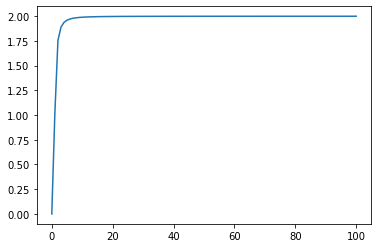

In [4]:
import matplotlib.pyplot as plt

def psi(x, M=1, a=1):
    x = x ** 2

    if x <= M:
        return x

    return M + M ** (1 + a) * (M ** (-a) - x ** (-a)) / a


x = np.linspace(0,100,100)
y = np.linspace(0,100,100)
for i,xx in enumerate(x):
    y[i] = psi(xx)
    
    
plt.plot(x,y)

In [8]:
sig = np.array([1,2,3,4,5,6,6,6,3,3,1])

In [ ]:
def norm(x):
    return np.linalg.norm(x)

def phi(x, order):
    x = np.array(x)

    a = x ** 2
    a[0] -= psi(norm(x))

    f = lambda z: np.dot(a, [z ** (2 * m) for m in range(len(a))])

    return brentq(f, 0, 5)

def get_keys(dim, order):
    s = tosig.sigkeys(dim, order)

    tuples = []

    for t in s.split():
        if len(t) > 2:
            t = t.replace(")", ",)")

        tuples.append(ast.literal_eval(t))

    return tuples

def Phi(X, order, normalise=True, compute_sigs=True):
    if compute_sigs:
        dim = np.shape(X)[1]
        sig = tosig.stream2sig(np.array(X), order)
    else:
        dim = 2
        sig = np.array(X)

    if not normalise:
        return sig

    keys = get_keys(dim, order)

    phi_x = phi(tuple(sig), order)
    Lambda = np.array([phi_x ** len(t) for t in keys])
    return Lambda * sig

def T(set1, set2, order, verbose=True, normalise=True, compute_sigs=True):
    m = len(set1)
    n = len(set2)

    X = Parallel(n_jobs=1)(delayed(Phi)(path, order, normalise, compute_sigs) for path in tqdm(set1, desc="Computing signatures of population 1", disable=(not verbose)))
    Y = Parallel(n_jobs=1)(delayed(Phi)(path, order, normalise, compute_sigs) for path in tqdm(set2, desc="Computing signatures of population 2", disable=(not verbose)))

    XX = np.dot(X, np.transpose(X))
    YY = np.dot(Y, np.transpose(Y))
    XY = np.dot(X, np.transpose(Y))

    TU = 0.
    TU += XX.sum() / (m * m)
    TU += YY.sum() / (n * n)
    TU -= 2 * XY.sum() / (m * n)


    return TU

def c_alpha(m, alpha):
    K = 1.
    return 4 * np.sqrt(-np.log(alpha) / m)
    return (2 * K / m) * (1 + np.sqrt(-2 * np.log(alpha))) ** 2

def test(set1, set2, order, confidence_level=0.99, **kwargs):
    """Statistical test to determine if two sets of paths come
    from the same distribution.

    The statistical test is based in the following paper:

    Chevyrev, I. and Oberhauser, H., 2018. Signature moments to
    characterize laws of stochastic processes. arXiv preprint
    arXiv:1810.10971.


    Parameters
    ----------
    set1 : list of array
        Set of paths.
    set2 : list of array
        Set of paths.
    order : int
        Signature order.
    confidence_level : float, optional
        Confidence level of the statistical test. Must be in [0, 1].
        Default is 0.99, i.e. 99%.

    Returns
    -------
    bool
        True if the hypothesis is rejected and hence the sets come from
        different distributions, False otherwise.

    """

    assert len(set1) == len(set2), "Same size samples accepted for now."

    assert confidence_level >= 0. and confidence_level <= 1., "Confidence level must be in [0, 1]."

    m = len(set1)

    TU = T(set1, set2, order, **kwargs)
    c = c_alpha(m, confidence_level)
    print('c:', c)
    print('TU:', TU)

    return TU > c
